In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score  
from sklearn.metrics import precision_score,recall_score,f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# plt.rcParams['font.sans-serif'] = ['SimHei']

In [16]:
#features tagets
features = pd.read_csv('features.csv')
targets = pd.read_csv('targets.csv')
targets = targets['Disease']
# print(type(features))
features.head(1)

,Age,Sex,resting_BP,Serum_cholest,blood_sugar_exc120,Max_heart_rate,ind_exerc_angina,Angina_type,ST_dep_by_exerc,ind_for_slope_exerc,num_vessels_fluro,Thal_defect
0,63,male,145,233,True,150,False,typical,2.3,down,0,fixed


In [17]:
test = {
    'Age':[63,64,65,66],
    'Sex':['male','female','male','female'],
    'resting_BP':[145,146,147,148],
    'Serum_cholest':[233,234,222,252],
    'blood_sugar_exc120':[True,False,True,False],
    'Max_heart_rate':[150,140,130,120],
    'ind_exerc_angina':[False,True,False,True],
    'Angina_type':['typical','atypical','non-anginal','asymptomatic'],
    'ST_dep_by_exerc':[2.3,1.0,1.8,2.0],
    'ind_for_slope_exerc':['up','down','flat','up'],
    'num_vessels_fluro':[0,1,2,3],
    'Thal_defect':['normal','fixed','recersable','recersable']
}
test = pd.DataFrame(test)
test

,Age,Sex,resting_BP,Serum_cholest,blood_sugar_exc120,Max_heart_rate,ind_exerc_angina,Angina_type,ST_dep_by_exerc,ind_for_slope_exerc,num_vessels_fluro,Thal_defect
0,63,male,145,233,True,150,False,typical,2.3,up,0,normal
1,64,female,146,234,False,140,True,atypical,1.0,down,1,fixed
2,65,male,147,222,True,130,False,non-anginal,1.8,flat,2,recersable
3,66,female,148,252,False,120,True,asymptomatic,2.0,up,3,recersable


### How one-hot coding works
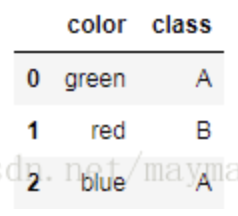
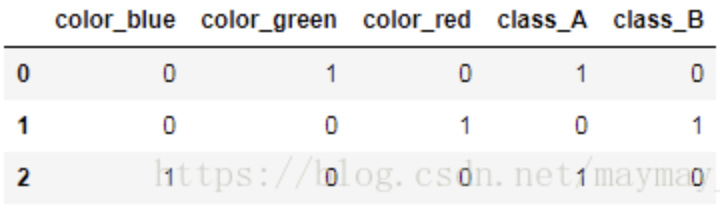

In [18]:
# The discrete data should be one-hot encoded, 
# the continuous data should be standardized, and then merged
# Here, onehot encoding is performed first, and then standardized, in one step (there may be some errors)
features = pd.get_dummies(features)  # one-hot encoding
features_names = features.columns
sc = StandardScaler()
features = sc.fit_transform(features) # standardized 
X_train,X_test,y_train,y_test = train_test_split(features,targets,test_size = 0.25)
# features


In [19]:
#Plot accuracy and recall rate and ROC
# help(precision_recall_curve)
# three values be returns：accuracy recall threshold
from sklearn.metrics import precision_recall_curve 
# roc：return three values as well
from sklearn.metrics import roc_curve
# average accuracy
from sklearn.metrics import average_precision_score
#auc
from sklearn.metrics import auc

def prc_auc_plot(estimator,y_test,X_test):
    fig,axes = plt.subplots(1,2,figsize = (10,5))
    y_predict_proba = estimator.predict_proba(X_test)
    precisions,recalls,thresholds = precision_recall_curve(y_test,y_predict_proba[:,1])
    # print(thresholds)
    axes[0].plot(precisions,recalls)  
    axes[0].set_title('Average Precision：%.2f'%average_precision_score(y_test,y_predict_proba[:,1]))
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')

    fpr,tpr,thresholds = roc_curve(y_test,y_predict_proba[:,1])
    axes[1].plot(fpr,tpr)
    axes[1].set_title("AUC值：%.2f"%auc(fpr,tpr))
    axes[1].set_xlabel("FPR")
    axes[1].set_ylabel("TPR")
    
def my_print(x):
    if x == 1:
        print("Prediction：Sick")
    else:
        print("Prediction：Not Sick")

## k-nearest

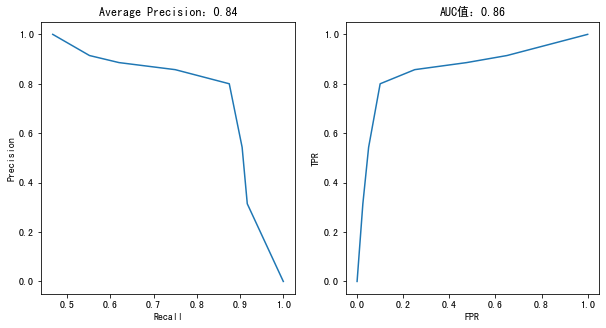

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(X_train,y_train)
prc_auc_plot(knn,y_test,X_test)

In [21]:
test.loc[4] = [63,'male',145,233,True,150,False,'typical',2.3,'down',0,'fixed']
print("Test Dataset:")
print(test.loc[4])
test_temp = pd.get_dummies(test)
test_temp = sc.transform(test_temp)
predict = knn.predict(test_temp)
my_print(predict[4])

Test Dataset:
Age                         63
Sex                       male
resting_BP                 145
Serum_cholest              233
blood_sugar_exc120        True
Max_heart_rate             150
ind_exerc_angina         False
Angina_type            typical
ST_dep_by_exerc            2.3
ind_for_slope_exerc       down
num_vessels_fluro            0
Thal_defect              fixed
Name: 4, dtype: object
Prediction：Not Sick


## Decision Tree

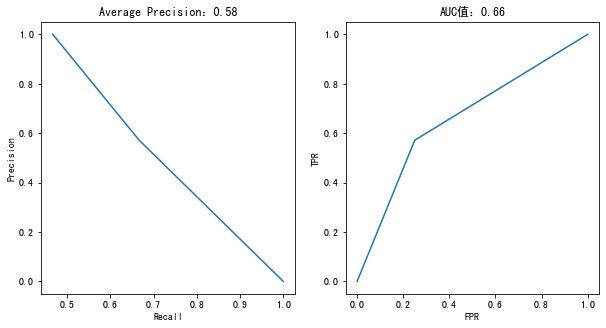

In [22]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth = 10)
dtree.fit(X_train,y_train)
prc_auc_plot(dtree,y_test,X_test)

In [23]:
from sklearn.tree import export_graphviz

export_graphviz(dtree,'dtree.dot',feature_names = features_names,class_names = ['False','True'])

In [25]:
test.loc[4] = [67,'male',160,286,False,108,True,'asymptomatic',1.5,'flat',3,'normal']
print("Test Dataset:")
print(test.loc[4])
test_temp = pd.get_dummies(test)
test_temp = sc.transform(test_temp)
predict = dtree.predict(test_temp)
my_print(predict[4])

Test Dataset:
Age                              67
Sex                            male
resting_BP                      160
Serum_cholest                   286
blood_sugar_exc120            False
Max_heart_rate                  108
ind_exerc_angina               True
Angina_type            asymptomatic
ST_dep_by_exerc                 1.5
ind_for_slope_exerc            flat
num_vessels_fluro                 3
Thal_defect                  normal
Name: 4, dtype: object
Prediction：Sick


## Random Forest

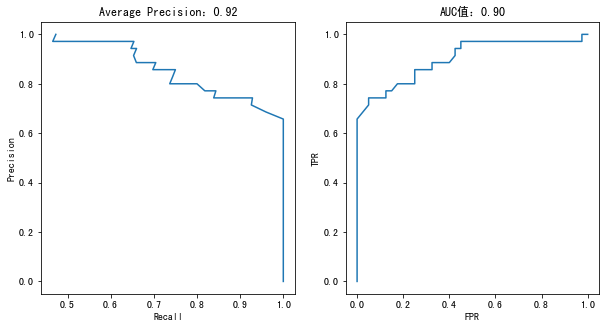

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train,y_train)
prc_auc_plot(rf,y_test,X_test)

In [27]:
test.loc[4] = [67,'male',160,286,False,108,True,'asymptomatic',1.5,'flat',3,'normal']
print("Test Dataset:")
print(test.loc[4])
test_temp = pd.get_dummies(test)
test_temp = sc.transform(test_temp)
predict = rf.predict(test_temp)
my_print(predict[4])

Test Dataset:
Age                              67
Sex                            male
resting_BP                      160
Serum_cholest                   286
blood_sugar_exc120            False
Max_heart_rate                  108
ind_exerc_angina               True
Angina_type            asymptomatic
ST_dep_by_exerc                 1.5
ind_for_slope_exerc            flat
num_vessels_fluro                 3
Thal_defect                  normal
Name: 4, dtype: object
Prediction：Sick


## Legistic Regression

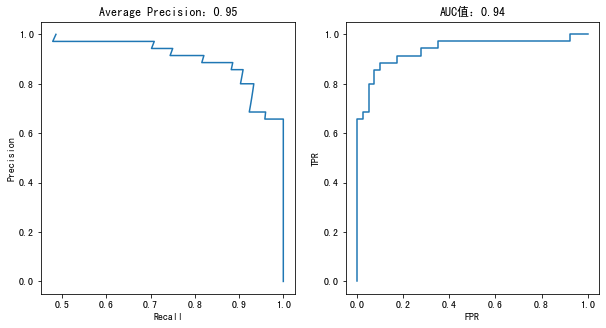

In [28]:
from sklearn.linear_model import LogisticRegression
logic = LogisticRegression()
logic.fit(X_train,y_train)
prc_auc_plot(logic,y_test,X_test)

In [29]:
test.loc[4] = [37,'male',130,250,False,187,False,'non-anginal',3.5,'down',0,'normal']
print("Test Dataset:")
print(test.loc[4])
test_temp = pd.get_dummies(test)
test_temp = sc.transform(test_temp)
predict = rf.predict(test_temp)
my_print(predict[4])

Test Dataset:
Age                             37
Sex                           male
resting_BP                     130
Serum_cholest                  250
blood_sugar_exc120           False
Max_heart_rate                 187
ind_exerc_angina             False
Angina_type            non-anginal
ST_dep_by_exerc                3.5
ind_for_slope_exerc           down
num_vessels_fluro                0
Thal_defect                 normal
Name: 4, dtype: object
Prediction：Not Sick
